In [1]:
import numpy as np
from numpy import random as rnd
from matplotlib import pyplot as plt
import warnings,itertools,math,os,sys,datetime,time

import torch

import pandas as pd

In [244]:
class GEN():
    def __init__(self,f0,c,det_c,coeff_c,noise_c,timesteps=10,seed=1):
        rnd.seed(seed)
        self.seed = seed
        self.timesteps = timesteps
        self.t = np.arange(0.001,self.timesteps+0.001,0.001)
        self.f0 = f0
        self.w = 2*np.pi*f0
        self.c = c
        assert len(det_c)==2,'Expected list of length 2 for deterministic coefficients.'
        assert len(coeff_c)==2,'Expected list of length 2 for frequency data coefficients.'
        assert len(noise_c)==2,'Expected list of length 2 for noise coefficients.'
        self.det_m = det_c[0]
        self.det_t = det_c[1]
        self.coeff_mu = coeff_c[0]
        self.coeff_sigma = coeff_c[1]
        self.noise_mu = noise_c[0]
        self.noise_sigma = noise_c[1]
        self.__get_components__()
        self.__get_series__()
        return
    def __get_components__(self):
        self.y_det = self.det_m*np.log(self.t) + self.det_t
        self.y_freq = sum([self.c[k]*np.exp(1j*self.w*self.t*(k-self.c.shape[0]//2)) for k in range(self.c.shape[0])])
        self.y_rand = self.noise_sigma*rnd.randn(self.t.shape[0]) + self.noise_mu
        return
    def __get_series__(self):
        self.y = self.y_det + self.y_freq + self.y_rand
        return
    def generate_stacked_featureset(self):
        return np.stack([np.real(self.y),np.imag(self.y)],axis=1)
    def generate_set(self,Lin,Lout,Loffset=0):
        yy = self.generate_stacked_featureset()
        X = []
        Y = []
        for k in range(Lin,yy.shape[0]-Loffset-Lout):
            X.append(yy[k-Lin:k])
            Y.append(yy[k+Loffset:k+Loffset+Lout])
        return np.array(X),np.array(Y)

In [245]:
yy = g.generate_stacked_featureset()

Lin = 100
Lout = 10
Loffset = 2

X = []
Y = []
for k in range(Lin,yy.shape[0]-Loffset-Lout):
    X.append(yy[k-Lin:k])
    Y.append(yy[k+Loffset:k+Loffset+Lout])

In [246]:
num_relev_coeff = 6
c = (np.real(coeff_sigma)*rnd.randn(num_relev_coeff) + np.real(coeff_mu)) + 1j*(np.imag(coeff_sigma)*rnd.randn(num_relev_coeff) + np.imag(coeff_mu))

In [264]:
g = GEN(
    f0=0.1,
    c=c,
    det_c=[1,0],
    coeff_c=[0+1j*0,1+1j*1],
    noise_c=[0,0],
    timesteps=100
)

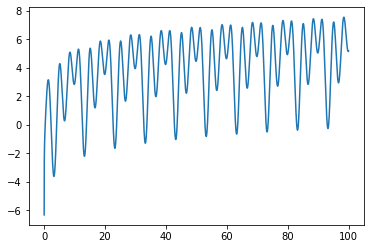

In [265]:
plt.plot(g.t,np.real(g.y))

In [266]:
X,Y = g.generate_set(Lin=100,Lout=10)

In [267]:
from statsmodels.tsa.arima.model import ARIMA

In [268]:
model = ARIMA(np.real(g.y),order=(5,1,0))

In [269]:
model_fit = model.fit()

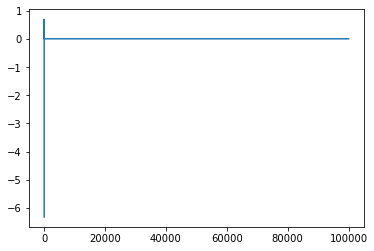

In [270]:
plt.plot(model_fit.resid)